<a href="https://colab.research.google.com/github/PattarapornH/Crab-Molting-Detection/blob/master/Molting_crab_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path_train = 'gdrive/My Drive/Year4/Project/dataset/'
path_molting_train = []
path_normal_train = []
for path in os.listdir(path_train + 'class_0'):
  path_molting_train.append(os.path.join(path_train+'class_0', path))
for path in os.listdir(path_train + 'class_1'):
  path_normal_train.append(os.path.join(path_train+'class_1', path))

In [31]:
len(path_molting_train),len(path_normal_train)

(305, 268)

In [32]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load training data
data = []
j = 0
k = 0
for i in range(536):
  if(i%10 == 0):
    print('.', end='')
# i%2 == 0 ? molting:normal
  try:
    if(i%2 == 0 and j < len(path_molting_train)):
      path = path_molting_train[j]
      img = load_img(path, target_size=(500, 500))
      data.append(img_to_array(img))
      j+=1
    if(i%2 == 1 and k < len(path_normal_train)):
      path = path_normal_train[k]
      img = load_img(path, target_size=(500, 500))
      data.append(img_to_array(img))
      k+=1
  except Exception as e:
    print(e)
    print(i)
    print(j)
    print(k)
    break
    
data = np.array(data)
print("\n",data.shape)

......................................................
 (536, 500, 500, 3)


In [0]:
label = [i%2 for i in range(536)]
label = np.array(label)

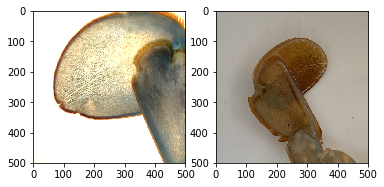

In [34]:
plt.subplot(121)
plt.imshow(data[0]/255)
plt.subplot(122)
plt.imshow(data[1]/255)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5, random_state = 20)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range = [0.0,1.0],
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator = train_datagen.flow(X_train,y_train,batch_size=32)

<Figure size 432x288 with 0 Axes>

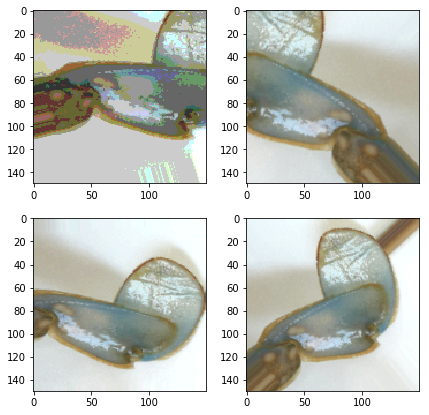

In [37]:
from keras.preprocessing.image import array_to_img

plt.clf()
fnames = [os.path.join(path_train+'class_0', fname) for fname in os.listdir(path_train+'class_0')]
img_path = fnames[21]

img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
plt.figure(figsize=(7,7))

i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(2, 2, i + 1)
    plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow(X_test,y_test,batch_size=32)
valid_generator = test_datagen.flow(X_valid,y_valid,batch_size=32)

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

# Init CNN
model = Sequential()

# Convolution
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(500, 500, 3)))

# Pooling
model.add(MaxPooling2D((2, 2)))

# Second layer of convolution
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third layer of convolution
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flattening
model.add(Flatten())

# Dropout
model.add(Dropout(0.5))

# Full Connection
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 498, 498, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 247, 247, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 121, 121, 128)     73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 460800)           

In [40]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

train_model = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs= 50,
    validation_data=valid_generator,)

Epoch 1/50
10/10 [==============================] - 18s 2s/step - loss: 0.5026 - acc: 0.7642 - val_loss: 0.5070 - val_acc: 0.7778
Epoch 2/50
10/10 [==============================] - 16s 2s/step - loss: 0.5062 - acc: 0.7374 - val_loss: 0.6458 - val_acc: 0.7222
Epoch 3/50
10/10 [==============================] - 17s 2s/step - loss: 0.5096 - acc: 0.7312 - val_loss: 0.4641 - val_acc: 0.7778
Epoch 4/50
10/10 [==============================] - 16s 2s/step - loss: 0.5021 - acc: 0.7625 - val_loss: 0.5500 - val_acc: 0.7963
Epoch 5/50
10/10 [==============================] - 17s 2s/step - loss: 0.5015 - acc: 0.7688 - val_loss: 0.5925 - val_acc: 0.7778
Epoch 6/50
10/10 [==============================] - 16s 2s/step - loss: 0.4817 - acc: 0.7751 - val_loss: 0.5358 - val_acc: 0.7778
Epoch 7/50
10/10 [==============================] - 16s 2s/step - loss: 0.4614 - acc: 0.7625 - val_loss: 0.3653 - val_acc: 0.7963
Epoch 8/50
10/10 [==============================] - 16s 2s/step - loss: 0.4839 - acc: 0.74

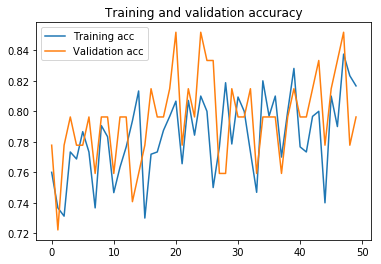

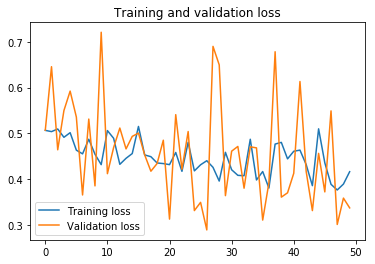

In [41]:
acc = train_model.history['acc']
val_acc = train_model.history['val_acc']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [42]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.581798964076572
Test accuracy: 0.7777777888156749


In [0]:
predicted = model.predict_classes(X_test)
prob = model.predict_proba(X_test)

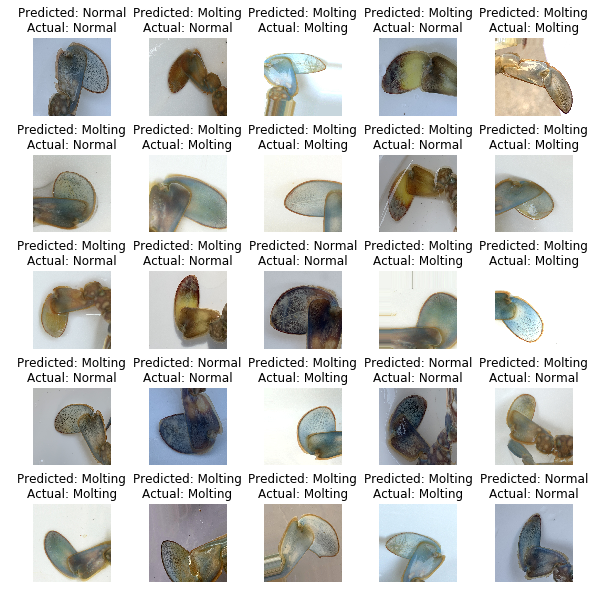

In [44]:
plt.figure(figsize=(10,10))
proba = 0
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(wspace = 0.2,hspace = 0.5)
    if(predicted[i] == 0):
        res = 'Molting'
        proba = round(float(1-prob[i][0])*100.0,2)  # probability assigned to class 1 in sigmoid
    else:
        res = 'Normal'
        proba = round((float(prob[i][0]))*100.0,2)
    
    if(y_test[i] == 0):
      act = "Molting"
    else:
      act = "Normal"
    title = "Predicted: "+res+"\nActual: "+ act
    plt.title(title)
    plt.axis('off')
    plt.imshow(X_test[i]/255)